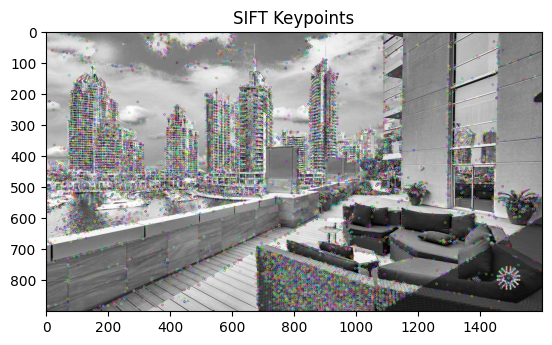

In [ ]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread('/content/img.webp', cv2.IMREAD_GRAYSCALE)
sift = cv2.SIFT_create()
keypoints, descriptors = sift.detectAndCompute(img, None)
img_sift = cv2.drawKeypoints(img, keypoints, None)

plt.imshow(img_sift)
plt.title("SIFT Keypoints")
plt.show()


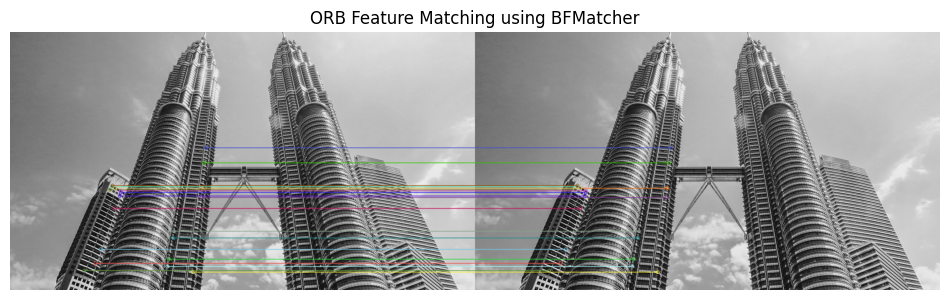

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the uploaded images
img1 = cv2.imread('/content/img_3.jpg')  # Replace with your actual image name
img2 = cv2.imread('/content/img_3.jpg')  # Replace with your actual image name

# Convert to grayscale
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# === SIFT ===
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(gray1, None)
kp2, des2 = sift.detectAndCompute(gray2, None)

img_sift = cv2.drawKeypoints(gray1, kp1, img1)
plt.imshow(cv2.cvtColor(img_sift, cv2.COLOR_BGR2RGB))
plt.title("SIFT Keypoints")
plt.axis('off')
plt.show()

# === ORB + BFMatcher ===
orb = cv2.ORB_create()
kp3, des3 = orb.detectAndCompute(gray1, None)
kp4, des4 = orb.detectAndCompute(gray2, None)

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des3, des4)
matches = sorted(matches, key=lambda x: x.distance)

img_matches = cv2.drawMatches(img1, kp3, img2, kp4, matches[:20], None, flags=2)
plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
plt.title("ORB + BFMatcher")
plt.axis('off')
plt.show()

# === Contour Detection ===
gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

img_contours = img1.copy()
cv2.drawContours(img_contours, contours, -1, (0,255,0), 2)

plt.imshow(cv2.cvtColor(img_contours, cv2.COLOR_BGR2RGB))
plt.title("Contour Detection")
plt.axis('off')
plt.show()


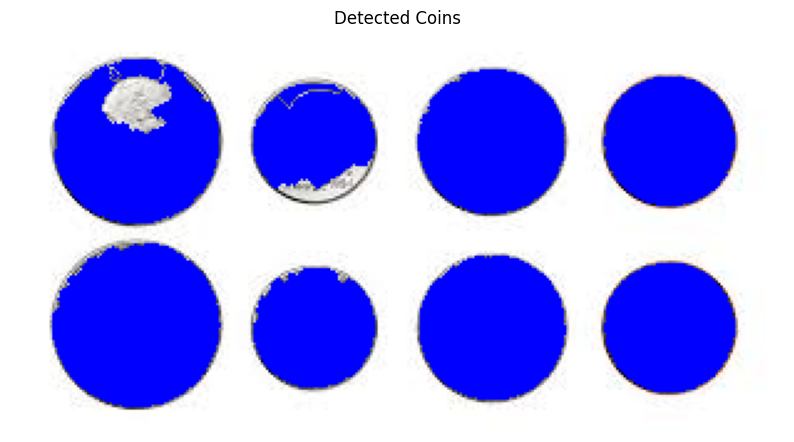

Number of coins detected: 11


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess image
img = cv2.imread('/content/download.jpeg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (5, 5), 0)

# Threshold (binary inverse + Otsu)
ret, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Noise removal with morphological opening
kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

# Sure background area via dilation
sure_bg = cv2.dilate(opening, kernel, iterations=3)

# Sure foreground area using distance transform
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.2 * dist_transform.max(), 255, 0)
sure_fg = np.uint8(sure_fg)

# Unknown region = background - foreground
unknown = cv2.subtract(sure_bg, sure_fg)

# Marker labeling
ret, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1  # Make sure background is not 0
markers[unknown == 255] = 0

# Apply Watershed
markers = cv2.watershed(img, markers)

# Create a copy of the original image
result = img.copy()

# Fill ONLY the detected regions (coins) with solid red
result[markers > 1] = [255, 0, 0]  # BGR format (red)



# Display the result
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.title("Detected Coins")
plt.axis('off')
plt.show()

# Count the number of coins (subtract 1 for background)
num_coins = markers.max() - 1
print(f"Number of coins detected: {num_coins}")

In [ ]:
!pip install torch torchvision matplotlib

import torch
import torchvision
import torchvision.transforms as transforms

# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet expects 224x224
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load CIFAR-100
trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

import torchvision.models as models
import torch.nn as nn

# Load and modify ResNet-18 and ResNet-34
def load_model(model_type='resnet18'):
    model = getattr(models, model_type)(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, 100)  # 100 classes in CIFAR-100
    return model

import torch.optim as optim
import time

def train_model(model, trainloader, criterion, optimizer, device, epochs=2):
    model.to(device)
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}")

def evaluate_model(model, testloader, device):
    model.eval()
    correct = 0
    total = 0
    total_time = 0.0
    criterion = nn.CrossEntropyLoss()
    test_loss = 0.0

    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            start_time = time.time()
            outputs = model(images)
            total_time += time.time() - start_time
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    avg_loss = test_loss / len(testloader)
    avg_time = total_time / len(testloader)

    print(f"Accuracy: {accuracy:.2f}%")
    print(f"Loss: {avg_loss:.4f}")
    print(f"Inference Time per Batch: {avg_time:.4f} seconds")
    return accuracy, avg_loss, avg_time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ResNet-18
resnet18 = load_model('resnet18')
optimizer18 = optim.Adam(resnet18.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

print("Training ResNet-18")
train_model(resnet18, trainloader, criterion, optimizer18, device)
print("Evaluating ResNet-18")
acc18, loss18, time18 = evaluate_model(resnet18, testloader, device)

# ResNet-34
resnet34 = load_model('resnet34')
optimizer34 = optim.Adam(resnet34.parameters(), lr=0.001)

print("\nTraining ResNet-34")
train_model(resnet34, trainloader, criterion, optimizer34, device)
print("Evaluating ResNet-34")
acc34, loss34, time34 = evaluate_model(resnet34, testloader, device)

# Comparison Summary
print("\n📊 Comparison:")
print(f"ResNet-18 -> Accuracy: {acc18:.2f}%, Loss: {loss18:.4f}, Time: {time18:.4f}s")
print(f"ResNet-34 -> Accuracy: {acc34:.2f}%, Loss: {loss34:.4f}, Time: {time34:.4f}s")



/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 82.7MB/s]


Training ResNet-18
Epoch 1, Loss: 1.973293262217051
Epoch 2, Loss: 1.191707715506444
Evaluating ResNet-18
Accuracy: 62.45%
Loss: 1.3171
Inference Time per Batch: 0.0036 seconds


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 181MB/s]



Training ResNet-34
Epoch 1, Loss: 2.260915397378185
Epoch 2, Loss: 1.3764877140979328
Evaluating ResNet-34
Accuracy: 58.48%
Loss: 1.4820
Inference Time per Batch: 0.0058 seconds

📊 Comparison:
ResNet-18 -> Accuracy: 62.45%, Loss: 1.3171, Time: 0.0036s
ResNet-34 -> Accuracy: 58.48%, Loss: 1.4820, Time: 0.0058s
